In [1]:
import os,sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.special import erf
import pandas as pd
from astropy.table import Table, vstack
import scipy
import scipy.constants as constants

packpath = "/global/homes/c/cpopik/Packages/"  # This is where your packages should be

sys.path.append(packpath)

sys.path.append(packpath + "hmvec/")
import camb
import hmvec as hm

sys.path.append(packpath+"emu_CAMELS/")
sys.path.append(packpath+"emu_CAMELS/ostrich/")
sys.path.append(packpath+"emu_CAMELS/scripts/1P_emulator")
import helper_functions_1P as fs

homepath = "/global/homes/c/cpopik"

# Create hmvec model

In [140]:
# Create model
zs = np.linspace(0, 1.5, 20)  # 20, DOES change MCMC time
ms = np.geomspace(10**12.5, 10**15, 200)
ks = np.geomspace(1e-4, 100, 1001)  # 1001, doesn't really change MCMC time
hcos = hm.HaloModel(zs, ks, ms=ms)

xmax = 20  # 20, doesn't really change MCMC time
nxs = 5000  # 5000, DOES change MCMC Time


hcos.add_battaglia_pres_profile("y",family='pres', xmax=xmax,nxs=nxs, ignore_existing=True)

In [141]:
family='pres'

if family is None: family = hcos.p['battaglia_pres_family'] # AGN or SH?
pparams = {}
pparams['battaglia_pres_gamma'] = hcos.p['battaglia_pres_gamma']
pparams['battaglia_pres_alpha'] = hcos.p['battaglia_pres_alpha']
pparams.update(hm.battaglia_defaults[family])


# Convert masses to m200critz
rhocritz = hcos.rho_critical_z(hcos.zs)
if hcos.mdef=='vir':
    delta_rhos1 = rhocritz*hcos.deltav(hcos.zs)
elif hcos.mdef=='mean':
    delta_rhos1 = hcos.rho_matter_z(hcos.zs)*200.
rvirs = hcos.rvir(hcos.ms[None,:],hcos.zs[:,None])
cs = hcos.concentration()
delta_rhos2 = 200.*hcos.rho_critical_z(hcos.zs)
m200critz = hm.mdelta_from_mdelta(hcos.ms,cs,delta_rhos1,delta_rhos2)
r200critz = hm.R_from_M(m200critz,hcos.rho_critical_z(hcos.zs)[:,None],delta=200.)

# Generate profiles
"""
The physical profile is rho(r) = f(2r/R200)
We rescale this to f(x), so x = r/(R200/2) = r/rgs
So rgs = R200/2 is the equivalent of rss in the NFW profile
"""
omb = hcos.p['ombh2'] / hcos.h**2.
omm = hcos.om0
presFunc = lambda x: hm.P_e_generic_x(x,m200critz[...,None],r200critz[...,None],hcos.zs[:,None,None],omb,omm,rhocritz[...,None,None],
                            alpha=pparams['battaglia_pres_alpha'],
                            gamma=pparams['battaglia_pres_gamma'],
                            P0_A0=pparams['P0_A0'],
                            P0_alpham=pparams['P0_alpham'],
                            P0_alphaz=pparams['P0_alphaz'],
                            xc_A0=pparams['xc_A0'],
                            xc_alpham=pparams['xc_alpham'],
                            xc_alphaz=pparams['xc_alphaz'],
                            beta_A0=pparams['beta_A0'],
                            beta_alpham=pparams['beta_alpham'],
                            beta_alphaz=pparams['beta_alphaz'])

rgs = r200critz
cgs = rvirs/rgs
sigmaT=constants.physical_constants['Thomson cross section'][0] # units m^2
mElect=constants.physical_constants['electron mass'][0] / hm.default_params['mSun']# units kg
ks,pkouts = hm.generic_profile_fft(presFunc,cgs,rgs[...,None],hcos.zs,hcos.ks,xmax,nxs,do_mass_norm=False)
pk_profile = pkouts.copy()*4*np.pi*(sigmaT/(mElect*constants.c**2))*(r200critz**3*((1+hcos.zs)**2/hcos.h_of_z(hcos.zs))[...,None])[...,None]   

# Make emulator

In [142]:
home=packpath+'emu_CAMELS/emulator_profiles/1P_set/' #point to your profiles
suite='SIMBA'  # Simulation suite to emulate (SIMBA, IllustrisTNG)
vary_str='ASN1'  # Feedback parameter (ASN1/2, AAGN1/2)
prof='pth_mean' # Profile to output (rho_mean, rho_med, pth_mean, pth_med)
func_str='linear' #this is the Rbf interpolation function

#  Currently understand these to be inherent parameters of the simulation suite
mass=fs.mass
mass_str=fs.mass_str
snap=fs.snap
z=fs.choose_redshift(suite)
vary,sims=fs.choose_vary(vary_str)
samples=fs.cartesian_prod(vary,z,mass)
nsamp=samples.shape[0]

samples, rs, y, emulator=fs.build_emulator_3D(home,suite,vary_str,prof,func_str)

In [186]:
zsgrid = np.meshgrid(hcos.zs, np.log10(hcos.ms))[0]
msgrid = np.meshgrid(hcos.zs, np.log10(hcos.ms))[1]

def emu_profiles(A, emulator):
    Asgrid = A*np.ones(zsgrid.shape)
    params = np.array((Asgrid, zsgrid, msgrid)).T.reshape(hcos.zs.size*hcos.ms.size, 3)
    profiles = 10**(emulator(params).T.reshape(hcos.zs.size, hcos.ms.size, rs.size))
    return profiles

In [187]:
A = 1

unitconversion = (14/27)*(3.086e24/1.989e33)  # go from cgs to solar masses and Mpc, and P_th to P_e
Pe_emu = unitconversion*emu_profiles(A, emulator)  
# At this point we should have what is called presFunc

In [188]:
xs = np.linspace(0.,xmax,nxs+1)[1:]
xs_emu = rs[None, None, :]/rgs[:, :, None]  # dimensions should be (xdim)
rs_hm = xs[None, None, :]*rgs[:, :, None]

print(max(np.ravel(Pe_emu[:, :, 0]/presFunc(xs)[:, :, 0])), 
      min(np.ravel(Pe_emu[:, :, 0]/presFunc(xs)[:, :, 0])))

237.58689855583563 0.09364203422835435


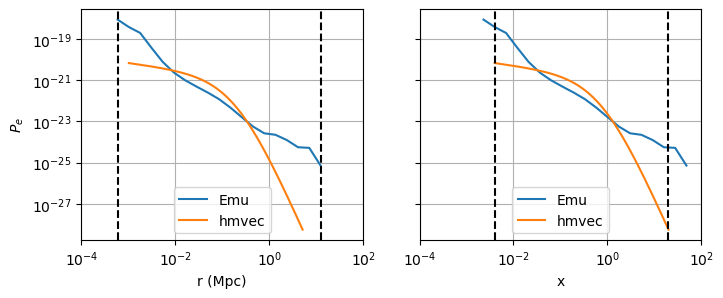

In [182]:
i, j = 10, 15

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8, 3))

ax1.grid(), ax1.loglog(), ax1.set_xlim(1e-4, 1e2)
ax1.plot(rs, Pe_emu[i,j], label='Emu')
ax1.plot(rs_hm[i, j], presFunc(xs)[i, j], label='hmvec')
ax1.set_xlabel('r (Mpc)', fontsize=10), ax1.set_ylabel('$P_e$', fontsize=10)
ax1.axvline(min(rs), c='k', ls='--'), ax1.axvline(max(rs), c='k', ls='--')
ax1.legend()

ax2.grid(), ax2.loglog(), ax2.set_xlim(1e-4, 1e2)
ax2.plot(xs_emu[i, j], Pe_emu[i,j], label='Emu')
ax2.plot(xs, presFunc(xs)[i, j], label='hmvec')
ax2.set_xlabel('x', fontsize=10)
ax2.axvline(min(xs), c='k', ls='--'), ax2.axvline(max(xs), c='k', ls='--')
ax2.legend()

plt.show()

In [147]:
xs_emu = rs[None, None, :]/rgs[:, :, None]  # dimensions should be (xdim)
rss = r200critz
rvir = hcos.rvir(hcos.ms[None,:],hcos.zs[:,None])
cmaxs = rvir/rss  # Dimension should be (zim, mdim)

ks_emu, profileemuhm = hm.fft.generic_profile_fft_r(Pe_emu, xs_emu, cmaxs, rss[..., None], hcos.zs, hcos.ks, do_mass_norm=False)

# At this points we should have what is called pkouts

In [148]:
print(max(np.ravel(profileemuhm/pkouts)), 
      min(np.ravel(profileemuhm/pkouts)))

1973.1891615962488 -12.930024580800259


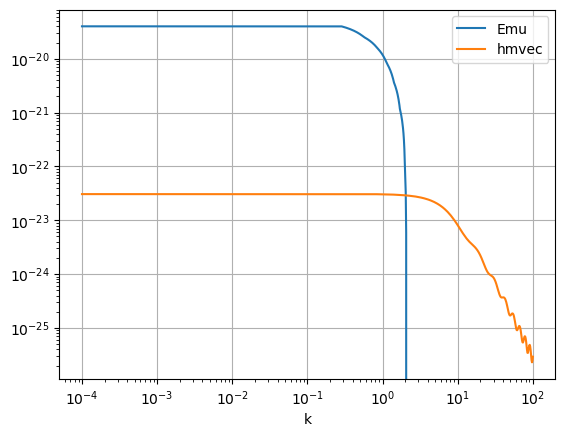

In [149]:
i, j = 10, 15

plt.grid(), plt.loglog()
plt.plot(ks_emu, profileemuhm[i, j], label='Emu')
plt.plot(hcos.ks, pkouts[i, j], label='hmvec')
plt.xlabel('k')
plt.legend()
plt.show()

In [150]:
unitconversion2 = 4*np.pi*(sigmaT/(mElect*constants.c**2))* \
                (r200critz**3*((1+hcos.zs)**2/hcos.h_of_z(hcos.zs))[...,None])[...,None] 

hcos.add_custom_pressure_profile(unitconversion2*profileemuhm, 'y_emu')

In [151]:
print(max(np.ravel(hcos.pk_profiles['y_emu']/hcos.pk_profiles['y'])), 
      min(np.ravel(hcos.pk_profiles['y_emu']/hcos.pk_profiles['y'])))

1973.189161596249 -12.930024580800259


[]

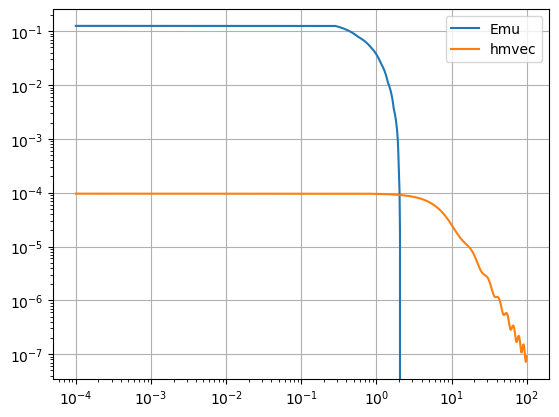

In [152]:
i, j = 10, 15

plt.grid(), plt.loglog()
plt.plot(hcos.ks, hcos.pk_profiles['y_emu'][i,j], label='Emu')
plt.plot(hcos.ks, hcos.pk_profiles['y'][i, j], label='hmvec')
plt.legend()
plt.plot()

In [153]:
Pyyemu = hcos.get_power('y_emu', verbose=False)
Pyy = hcos.get_power('y', verbose=False);

[]

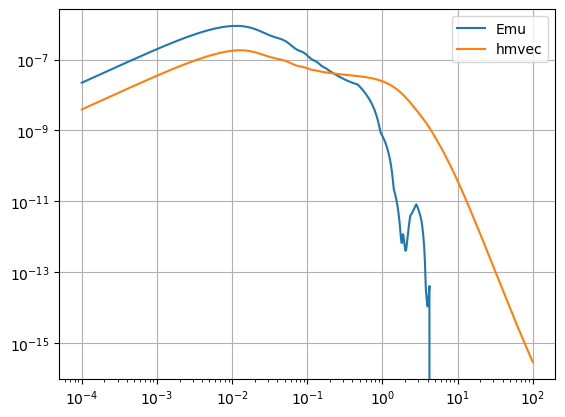

In [154]:
i = 1

plt.grid(), plt.loglog()
plt.plot(hcos.ks, Pyyemu[i], label='Emu')
plt.plot(hcos.ks, Pyy[i], label='hmvec')
plt.legend()
plt.plot()